In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import gc

In [28]:
def reduce_mem_usage(df, verbose=True):

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
#
def autocorrelation(ys, t=1):
    return np.corrcoef(ys[:-t], ys[t:])

In [29]:
def preprocess_sales(sales, start=1400, upper=1970):
    '''process sales data
    '''
    if start is not None:
        print("dropping...")
        to_drop = [f"d_{i+1}" for i in range(start-1)]
        print(sales.shape)
        sales.drop(to_drop, axis=1, inplace=True)
        print(sales.shape)
    #=======
    print("adding...")
    new_columns = ['d_%i'%i for i in range(1942, upper, 1)] # 1942-1970 
    for col in new_columns:
        sales[col] = np.nan
    print("melting...")
    sales = sales.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id","scale","start"],
                        var_name='d', value_name='demand')

    print("generating order")
    if start is not None:
        skip = start
    else:
        skip = 1
    sales["nb"] = sales.index // 42840 + skip
    return sales
#===============================================================
def preprocess_calendar(calendar):
    '''clean and transform calendar data
    '''
    global maps, mods
    calendar["event_name"] = calendar["event_name_1"]
    calendar["event_type"] = calendar["event_type_1"]

    map1 = {mod:i for i,mod in enumerate(calendar['event_name'].unique())}
    calendar['event_name'] = calendar['event_name'].map(map1)
    map2 = {mod:i for i,mod in enumerate(calendar['event_type'].unique())}
    calendar['event_type'] = calendar['event_type'].map(map2)
    calendar['nday'] = calendar['date'].str[-2:].astype(int)
    maps["event_name"] = map1
    maps["event_type"] = map2
    mods["event_name"] = len(map1)
    mods["event_type"] = len(map2)
    calendar["wday"] -=1
    calendar["month"] -=1
    calendar["year"] -= 2011
    mods["month"] = 12
    mods["year"] = 6
    mods["wday"] = 7
    mods['snap_CA'] = 2
    mods['snap_TX'] = 2
    mods['snap_WI'] = 2

    calendar.drop(["event_name_1", "event_name_2", "event_type_1", "event_type_2", "date", "weekday"], 
                  axis=1, inplace=True)
    return calendar
#=========================================================
def make_dataset(categorize=False ,start=1400, upper= 1970):
    global maps, mods
    print("loading calendar...")
    calendar = pd.read_csv("calendar.csv")
    print("loading sales...")
    sales = pd.read_csv("sales.csv")
    cols = ["item_id", "dept_id", "cat_id","store_id","state_id"]
    if categorize:
        for col in cols:
            temp_dct = {mod:i for i, mod in enumerate(sales[col].unique())}
            mods[col] = len(temp_dct)
            maps[col] = temp_dct
        for col in cols:
            sales[col] = sales[col].map(maps[col])
        #

    sales =preprocess_sales(sales, start=start, upper= upper)
    calendar = preprocess_calendar(calendar)
    calendar = reduce_mem_usage(calendar)
    print("merge with calendar...")
    sales = sales.merge(calendar, on='d', how='left')
    del calendar

    print("reordering...")
    sales.sort_values(by=["id","nb"], inplace=True)
    print("re-indexing..")
    sales.reset_index(inplace=True, drop=True)
    gc.collect()

    sales['n_week'] = (sales['nb']-1)//7
    sales["nday"] -= 1
    mods['nday'] = 31
    sales = reduce_mem_usage(sales)
    gc.collect()
    return sales
#===============================================================================#


In [30]:
%%time
CATEGORIZE = True;
START = 1400; UPPER = 1970;
maps = {}
mods = {}
sales = make_dataset(categorize=CATEGORIZE ,start=START, upper= UPPER)
sales["x"] = sales["demand"] / sales["scale"]
LAGS = [28, 35, 42, 49, 56, 63]
FEATS = []
for lag in tqdm(LAGS):
    sales[f"x_{lag}"] = sales.groupby("id")["x"].shift(lag)
    FEATS.append(f"x_{lag}")
#

loading calendar...
loading sales...
dropping...
(42840, 1949)
(42840, 550)
adding...
melting...
generating order
Mem. usage decreased to  0.04 Mb (77.3% reduction)
merge with calendar...
reordering...
re-indexing..
Mem. usage decreased to 1001.37 Mb (59.8% reduction)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.84s/it]

Wall time: 44.2 s


In [31]:
def pinball_loss(y_true, y_pred, quantile):
    e = y_true - y_pred
    return np.maximum(quantile * e, (quantile - 1) * e)

def calculate_wspl(y_true, y_pred_quantiles, sales_weights, quantiles):
    wspl_scores = {}
    total_loss = 0
    for i, q in enumerate(quantiles):
        pb_loss = np.mean(pinball_loss(y_true, y_pred_quantiles[:, :, i], q), axis=1)
        wspl_score = np.sum(pb_loss * sales_weights) / np.sum(sales_weights)
        wspl_scores[q] = wspl_score
        total_loss += wspl_score
    return total_loss / len(quantiles), wspl_scores

In [32]:
sales.tail()

id  item_id  dept_id  cat_id  store_id  state_id   scale  start  \
24418795  WI_X     3059       11       3        12         2  1440.0      0   
24418796  WI_X     3059       11       3        12         2  1440.0      0   
24418797  WI_X     3059       11       3        12         2  1440.0      0   
24418798  WI_X     3059       11       3        12         2  1440.0      0   
24418799  WI_X     3059       11       3        12         2  1440.0      0   

               d  demand  ...  event_type  nday  n_week   x       x_28  \
24418795  d_1965     NaN  ...           0    14     280 NaN   7.667969   
24418796  d_1966     NaN  ...           0    15     280 NaN   7.988281   
24418797  d_1967     NaN  ...           0    16     280 NaN   8.898438   
24418798  d_1968     NaN  ...           0    17     281 NaN  10.234375   
24418799  d_1969     NaN  ...           1    18     281 NaN  10.335938   

               x_35       x_42       x_49       x_56       x_63  
24418795  10.242188   8.625000   6.964844   7.355469   7.562500  
24418796   9.382812   9.539062   7.234375   7.601562   8.453125  
24418797   9.218750   9.992188   9.414062   8.890625  10.234375  
24418798  13.132812  12.125000  10.703125  10.320312  10.648438  
24418799  13.179688   9.906250  10.523438   9.953125  10.343750  

[5 rows x 29 columns]

In [33]:
print(sales.shape)
sales = sales.loc[sales.nb>sales.start]
print(sales.shape)
nb = sales['nb'].values
MAX_LAG = max(LAGS)
#tr_mask = np.logical_and(nb>START + MAX_LAG, nb<=1913)
tr_mask = np.logical_and(nb>START + MAX_LAG, nb<=1941) # SORRY THIS IS FAKE VALIDATION. I DIDN'T THINK IT WOULD HAVE HAD LIFTED UP MY SCORE LIKE THAT
val_mask = np.logical_and(nb>1913, nb<=1941)
te_mask = np.logical_and(nb>1941, nb<=1969)
scale = sales['scale'].values
ids = sales['id'].values
#y = sales['demand'].values
#ys = y / scale
ys = sales['x'].values
Z = sales[FEATS].values
sv = scale[val_mask]
se = scale[te_mask]
ids = ids[te_mask]
ids = ids.reshape((-1, 28))
ca = sales[['snap_CA']].values
tx = sales[['snap_TX']].values
wi = sales[['snap_WI']].values
wday = sales[['wday']].values
month = sales[['month']].values
year = sales[['year']].values
event = sales[['event_name']].values
nday = sales[['nday']].values

(24418800, 29)
(24268220, 29)


In [34]:
sales.head()

id  item_id  dept_id  cat_id  store_id  state_id   scale  start  \
0  CA_1_FOODS     3056        7       2         0         0  465.75      0   
1  CA_1_FOODS     3056        7       2         0         0  465.75      0   
2  CA_1_FOODS     3056        7       2         0         0  465.75      0   
3  CA_1_FOODS     3056        7       2         0         0  465.75      0   
4  CA_1_FOODS     3056        7       2         0         0  465.75      0   

        d  demand  ...  event_type  nday  n_week         x  x_28  x_35  x_42  \
0  d_1400  2296.0  ...           0    27     199  4.929688   NaN   NaN   NaN   
1  d_1401  2984.0  ...           0    28     200  6.406250   NaN   NaN   NaN   
2  d_1402  3228.0  ...           0    29     200  6.929688   NaN   NaN   NaN   
3  d_1403  2868.0  ...           0     0     200  6.156250   NaN   NaN   NaN   
4  d_1404  2312.0  ...           0     1     200  4.964844   NaN   NaN   NaN   

   x_49  x_56  x_63  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 29 columns]

In [35]:
sales.tail()

id  item_id  dept_id  cat_id  store_id  state_id   scale  start  \
24418795  WI_X     3059       11       3        12         2  1440.0      0   
24418796  WI_X     3059       11       3        12         2  1440.0      0   
24418797  WI_X     3059       11       3        12         2  1440.0      0   
24418798  WI_X     3059       11       3        12         2  1440.0      0   
24418799  WI_X     3059       11       3        12         2  1440.0      0   

               d  demand  ...  event_type  nday  n_week   x       x_28  \
24418795  d_1965     NaN  ...           0    14     280 NaN   7.667969   
24418796  d_1966     NaN  ...           0    15     280 NaN   7.988281   
24418797  d_1967     NaN  ...           0    16     280 NaN   8.898438   
24418798  d_1968     NaN  ...           0    17     281 NaN  10.234375   
24418799  d_1969     NaN  ...           1    18     281 NaN  10.335938   

               x_35       x_42       x_49       x_56       x_63  
24418795  10.242188   8.625000   6.964844   7.355469   7.562500  
24418796   9.382812   9.539062   7.234375   7.601562   8.453125  
24418797   9.218750   9.992188   9.414062   8.890625  10.234375  
24418798  13.132812  12.125000  10.703125  10.320312  10.648438  
24418799  13.179688   9.906250  10.523438   9.953125  10.343750  

[5 rows x 29 columns]

In [36]:
item = sales[['item_id']].values
dept = sales[['dept_id']].values
cat = sales[['cat_id']].values
store = sales[['store_id']].values
state = sales[['state_id']].values
 
def make_data(mask):
    x = {"snap_CA":ca[mask], "snap_TX":tx[mask], "snap_WI":wi[mask], "wday":wday[mask], 
         "month":month[mask], "year":year[mask], "event":event[mask], "nday":nday[mask], 
         "item":item[mask], "dept":dept[mask], "cat":cat[mask], "store":store[mask], 
         "state":state[mask], "num":Z[mask]}
    t = ys[mask]
    return x, t
xt, yt = make_data(tr_mask) #train
xv, yv = make_data(val_mask) # val
xe, ye = make_data(te_mask) # test
 
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [84]:
#=====
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#============================#
def make_model(n_in):
    
    num = L.Input((n_in,), name="num")
    
    wday = L.Input((1,), name="wday")
    month = L.Input((1,), name="month")
    year = L.Input((1,), name="year")
    event = L.Input((1,), name="event")
    nday = L.Input((1,), name="nday")
    item = L.Input((1,), name="item")
    dept = L.Input((1,), name="dept")
    cat = L.Input((1,), name="cat")
    store = L.Input((1,), name="store")
    state = L.Input((1,), name="state")
    inp = {"snap_CA":ca, "snap_TX":tx, "snap_WI":wi, "wday":wday, 
           "month":month, "year":year, "event":event, "nday":nday,
           "item":item, "dept":dept, "cat":cat, "store":store, 
           "state":state, "num":num} 
    #

    wday_ = L.Embedding(mods["wday"], mods["wday"], name="wday_3d")(wday)
    month_ = L.Embedding(mods["month"], mods["month"], name="month_3d")(month)
    year_ = L.Embedding(mods["year"], mods["year"], name="year_3d")(year)
    event_ = L.Embedding(mods["event_name"], mods["event_name"], name="event_3d")(event)
    nday_ = L.Embedding(mods["nday"], mods["nday"], name="nday_3d")(nday)
    item_ = L.Embedding(mods["item_id"], 10, name="item_3d")(item)
    dept_ = L.Embedding(mods["dept_id"], mods["dept_id"], name="dept_3d")(dept)
    cat_ = L.Embedding(mods["cat_id"], mods["cat_id"], name="cat_3d")(cat)
    store_ = L.Embedding(mods["store_id"], mods["store_id"], name="store_3d")(store)
    state_ = L.Embedding(mods["state_id"], mods["state_id"], name="state_3d")(state)
    
    p = [ wday_, month_, year_, event_, nday_, item_, dept_, cat_, store_, state_]
    emb = L.Concatenate(name="embds")(p)
    context = L.Flatten(name="context")(emb)
    

    x = L.Concatenate(name="m1")([context,num ])
    x = L.Dense(125, activation="relu", name="d1")(x)
    x = L.Dropout(0.4)(x)
    x = L.Concatenate(name="m2")([x, context])
    x = L.Dense(125, activation="relu", name="d2")(x)
    preds = L.Dense(9, activation="linear", name="preds")(x)
    model = M.Model(inp, preds, name="M1")
    model.compile(loss=qloss, optimizer="adam")
    return model

In [85]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [86]:
net = make_model(len(FEATS))
ckpt = ModelCheckpoint("w.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
es = EarlyStopping(monitor='val_loss', patience=3)
print(net.summary())


Model: "M1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 wday (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 month (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 year (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 event (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                 

In [87]:
net.fit(xt, yt, batch_size=25_000, epochs=15, validation_data=(xv, yv), callbacks=[ckpt, reduce_lr, es])


Epoch 1/15
816/816 [==============================] - ETA: 0s - loss: 0.2163
Epoch 1: val_loss improved from inf to 0.22987, saving model to w.h5
816/816 [==============================] - 89s 107ms/step - loss: 0.2163 - val_loss: 0.2299 - lr: 0.0010
Epoch 2/15
  1/816 [..............................] - ETA: 1:33 - loss: 0.2035

C:\Users\devar\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


816/816 [==============================] - ETA: 0s - loss: 0.2024
Epoch 2: val_loss improved from 0.22987 to 0.22647, saving model to w.h5
816/816 [==============================] - 88s 108ms/step - loss: 0.2024 - val_loss: 0.2265 - lr: 0.0010
Epoch 3/15
816/816 [==============================] - ETA: 0s - loss: 0.2003
Epoch 3: val_loss improved from 0.22647 to 0.22442, saving model to w.h5
816/816 [==============================] - 93s 114ms/step - loss: 0.2003 - val_loss: 0.2244 - lr: 0.0010
Epoch 4/15
816/816 [==============================] - ETA: 0s - loss: 0.1991
Epoch 4: val_loss improved from 0.22442 to 0.22296, saving model to w.h5
816/816 [==============================] - 88s 108ms/step - loss: 0.1991 - val_loss: 0.2230 - lr: 0.0010
Epoch 5/15
816/816 [==============================] - ETA: 0s - loss: 0.1978
Epoch 5: val_loss improved from 0.22296 to 0.22195, saving model to w.h5
816/816 [==============================] - 84s 103ms/step - loss: 0.1978 - val_loss: 0.2219 - lr

In [88]:
nett = make_model(len(FEATS))
nett.load_weights("w.h5")

In [89]:
pv = nett.predict(xv, batch_size=25_000, verbose=1)
pe = nett.predict(xe, batch_size=25_000, verbose=1)

48/48 [==============================] - 1s 29ms/step


In [90]:
nett.evaluate(xv, yv, batch_size=50_000)


24/24 [==============================] - 2s 57ms/step - loss: 0.2180


0.21801720559597015

In [91]:
pv = pv.reshape((-1, 28, 9))
pe = pe.reshape((-1, 28, 9))

In [92]:
sv = sv.reshape((-1, 28))
se = se.reshape((-1, 28))

In [93]:
Yv = yv.reshape((-1, 28))

FOODS_2_338_TX_1


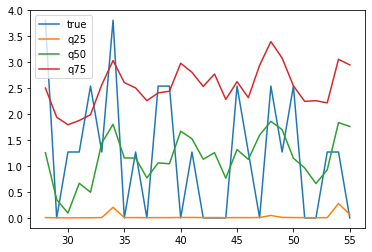

In [94]:
k = np.random.randint(0, 42840)
#k = np.random.randint(0, 200)
print(ids[k, 0])
plt.plot(np.arange(28, 56), Yv[k], label="true")
plt.plot(np.arange(28, 56), pv[k ,:, 3], label="q25")
plt.plot(np.arange(28, 56), pv[k ,:, 4], label="q50")
plt.plot(np.arange(28, 56), pv[k, :, 5], label="q75")
plt.legend(loc="best")
plt.show()

In [95]:
names = [f"F{i+1}" for i in range(28)]


In [96]:
piv = pd.DataFrame(ids[:, 0], columns=["id"])


In [97]:
QUANTILES = ["0.005", "0.025", "0.165", "0.250", "0.500", "0.750", "0.835", "0.975", "0.995"]
VALID = []
EVAL = []

for i, quantile in tqdm(enumerate(QUANTILES)):
    t1 = pd.DataFrame(pv[:,:, i]*sv, columns=names)
    t1 = piv.join(t1)
    t1["id"] = t1["id"] + f"_{quantile}_validation"
    t2 = pd.DataFrame(pe[:,:, i]*se, columns=names)
    t2 = piv.join(t2)
    t2["id"] = t2["id"] + f"_{quantile}_evaluation"
    VALID.append(t1)
    EVAL.append(t2)
#============#

9it [00:00, 33.77it/s]


In [98]:
sub = pd.DataFrame()
sub = sub.append(VALID + EVAL)
del VALID, EVAL, t1, t2

C:\Users\devar\AppData\Local\Temp/ipykernel_29300/238451928.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sub = sub.append(VALID + EVAL)


In [99]:
sub

id            F1            F2  \
0              CA_1_FOODS_0.005_validation   1890.088623   1821.255493   
1            CA_1_FOODS_1_0.005_validation    164.366211    161.578186   
2            CA_1_FOODS_2_0.005_validation    205.346985    196.437958   
3            CA_1_FOODS_3_0.005_validation   1174.498291   1153.358276   
4            CA_1_HOBBIES_0.005_validation    266.628754    256.716949   
...                                    ...           ...           ...   
42835  WI_HOUSEHOLD_2_513_0.995_evaluation      4.167096      3.827255   
42836  WI_HOUSEHOLD_2_514_0.995_evaluation      2.282560      2.275878   
42837  WI_HOUSEHOLD_2_515_0.995_evaluation      2.737375      2.685970   
42838  WI_HOUSEHOLD_2_516_0.995_evaluation      2.500105      2.692244   
42839                WI_X_0.995_evaluation  13010.334961  13068.031250   

                 F3            F4            F5            F6            F7  \
0       1699.446045   1848.445679   2068.387939   2332.590576   2170.731445   
1        158.996445    171.490341    187.132904    208.818863    175.354507   
2        176.964828    198.591003    225.798706    263.718719    233.685760   
3       1120.875244   1196.055054   1304.940430   1464.475952   1366.286499   
4        250.231461    264.632751    300.126923    329.525360    295.350098   
...             ...           ...           ...           ...           ...   
42835      4.044090      3.784651      4.023412      4.430842      4.419910   
42836      2.422131      2.358554      2.481726      2.755131      2.797710   
42837      2.865992      2.875986      2.958222      3.053994      3.074898   
42838      2.846164      2.547590      2.594168      3.002155      2.920069   
42839  13002.693359  12569.664062  15299.118164  20009.498047  18021.761719   

                 F8            F9  ...           F19           F20  \
0       1786.554199   1873.450928  ...   2044.480713   2284.674805   
1        151.042130    168.584518  ...    190.460709    200.194946   
2        191.560959    210.463013  ...    232.432693    250.761353   
3       1094.008667   1195.583252  ...   1317.111694   1451.455933   
4        239.254150    270.706970  ...    298.522797    325.090424   
...             ...           ...  ...           ...           ...   
42835      4.328925      4.185616  ...      4.497233      4.964496   
42836      2.426003      2.448692  ...      2.567133      2.762907   
42837      2.926794      2.693767  ...      3.014927      3.259564   
42838      2.745197      2.704802  ...      2.760160      3.018676   
42839  15069.655273  15296.048828  ...  17919.361328  28069.736328   

                F21           F22           F23           F24           F25  \
0       2197.698242   1877.255493   1795.892578   1801.259766   1822.931030   
1        178.666992    163.011032    164.343857    167.442398    176.380890   
2        233.996155    206.985458    194.350998    194.453018    197.352585   
3       1382.160278   1177.329346   1162.196045   1176.830444   1213.651978   
4        296.672089    262.000000    256.470459    248.801163    257.531372   
...             ...           ...           ...           ...           ...   
42835      4.875525      4.474091      4.223876      4.335823      4.140233   
42836      2.895192      2.391190      2.364414      2.484464      2.417006   
42837      3.224733      3.542049      2.781545      2.885946      2.976962   
42838      2.825775      2.593138      2.918632      2.928188      2.731180   
42839  26331.214844  17005.490234  17528.843750  19029.705078  16123.708008   

                F26           F27           F28  
0       2036.913330   2300.582275   2207.004883  
1        188.497620    198.268005    178.432831  
2        229.563934    253.580505    237.090714  
3       1302.655151   1462.931885   1395.594727  
4        299.175323    328.371979    305.049622  
...             ...           ...           ...  
42835      4.615778      5.007818      4.602261  
42836      3

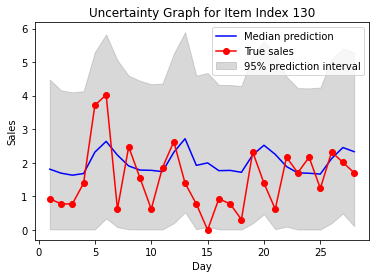

In [101]:
import matplotlib.pyplot as plt
import numpy as np

def plot_uncertainty(item_index, predictions, true_values=None):
    """
    Plot the prediction intervals and median prediction for a selected item.
    
    Parameters:
    - item_index: Index of the item in the predictions array.
    - predictions: Predictions array of shape (items, days, quantiles).
    - true_values: Actual sales values for the item, if available.
    """
    # Define quantiles
    quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]  # Example: 95% and 50% prediction intervals
    quantile_indices = [1, 3, 4, 5, 7]  # Indices of the quantiles in your predictions array, based on the order defined in your model
    
    days = np.arange(1, 29)  # Assuming predictions are for 28 days
    
    # Extract predictions for the specified quantiles
    lower_bound = predictions[item_index, :, quantile_indices[0]]
    upper_bound = predictions[item_index, :, quantile_indices[-1]]
    median_pred = predictions[item_index, :, quantile_indices[2]]
    
    # Plotting
    plt.fill_between(days, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% prediction interval')
    plt.plot(days, median_pred, label='Median prediction', color='blue')
    
    if true_values is not None:
        plt.plot(days, true_values[item_index], label='True sales', color='red', marker='o')
    
    plt.xlabel('Day')
    plt.ylabel('Sales')
    plt.title(f'Uncertainty Graph for Item Index {item_index}')
    plt.legend()
    plt.show()

# Example usage
item_index = 130  # Assuming 'k' is the index of the item you're interested in
plot_uncertainty(item_index, pv, Yv)  # For validation set visualization
# plot_uncertainty(item_index, pe)  # For test set visualization, if you have true values for the test set, include them similarly to Yv for validation


In [107]:
# Define your quantiles if not already defined
quantiles = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]

# Calculate sales weights. This is a placeholder and should be replaced with your actual calculation based on the last 28 days of sales
# sales_weights = calculate_sales_weights(sales_data)  # You need to implement this

# Reshape predictions if necessary to match the true values shape
# Note: Ensure pv and pe are reshaped correctly if your WSPL function expects a specific shape
pv_reshaped = pv.reshape((-1, 28, len(quantiles)))  # Adjust based on your actual data shape
pe_reshaped = pe.reshape((-1, 28, len(quantiles)))  # Adjust based on your actual data shape

# Flatten the true values and predictions if your WSPL function expects flat arrays
yvx_flat = yv.flatten()  # Adjust if necessary
ye_flat = ye.flatten()  # Adjust if necessary

# Calculate WSPL for the validation set
total_wspl_val, wspl_scores_val = calculate_wspl(yv_flat, pv_reshaped, sales_weights, quantiles)
print("Total WSPL for Validation Set:", total_wspl_val)
print("WSPL Scores by Quantile for Validation Set:", wspl_scores_val)

#


NameError: name 'yv_flat' is not defined